<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std    

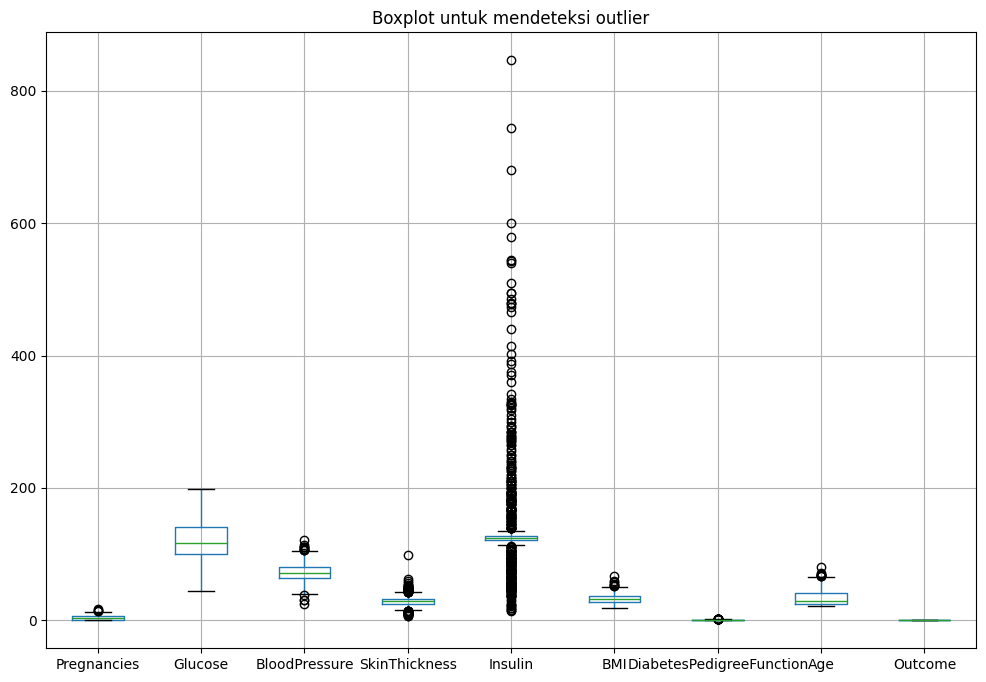

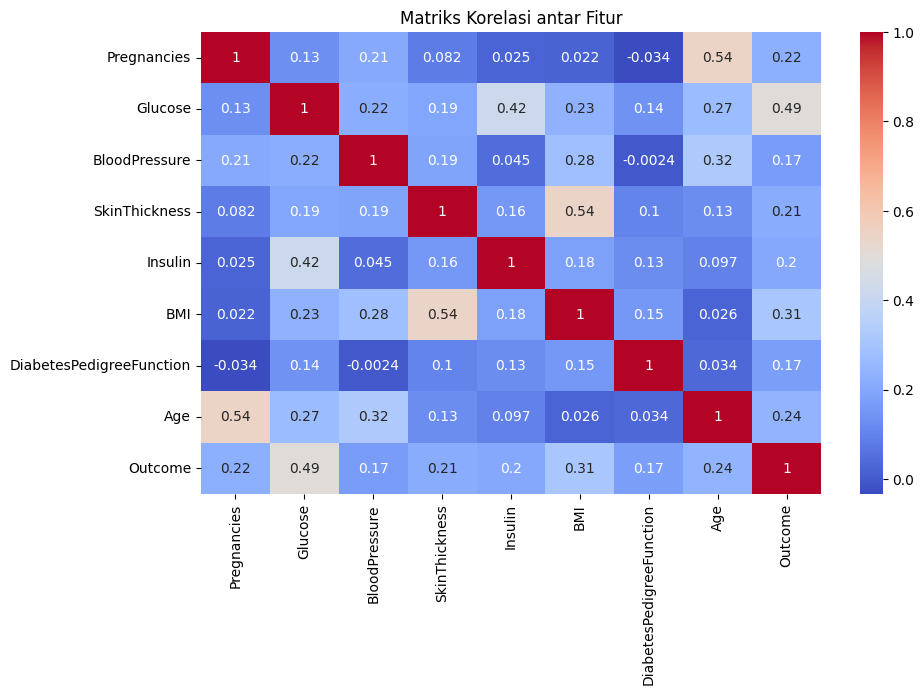

Akurasi Logistic Regression: 0.7532467532467533
Akurasi Random Forest: 0.7402597402597403
Akurasi XGBoost: 0.7402597402597403

=== Evaluasi XGBoost ===
[[76 23]
 [17 38]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        99
           1       0.62      0.69      0.66        55

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154


=== Kesimpulan Akhir ===
✗ Belum ada model yang mencapai akurasi 85% — Lakukan tuning atau balancing lebih lanjut.


In [ ]:
# Final Project ML - Klasifikasi Diabetes (Versi Akhir SMOTE + XGBoost)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 1. Load Dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# 2. Ganti nilai 0 menjadi NaN lalu isi dengan median
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].median())

# 3. Info data
print(df.info())
print(df.describe())
print("Jumlah duplikat:", df.duplicated().sum())
print("Missing values:\n", df.isnull().sum())

# 4. EDA: Boxplot
plt.figure(figsize=(12,8))
df.boxplot()
plt.title("Boxplot untuk mendeteksi outlier")
plt.show()

# 5. Korelasi
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matriks Korelasi antar Fitur")
plt.show()

# 6. Fitur dan target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 7. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 9. SMOTE untuk balancing data (hanya training set!)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f"Data sebelum SMOTE: {np.bincount(y_train)}")
print(f"Data sesudah SMOTE: {np.bincount(y_train_sm)}")

# 10. Model 1: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_sm, y_train_sm)
y_pred1 = logreg.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)
print("Akurasi Logistic Regression:", acc1)

# 11. Model 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred2 = rf.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)
print("Akurasi Random Forest:", acc2)

# 12. Model 3: XGBoost + SMOTE
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train_sm, y_train_sm)
y_pred3 = xgb.predict(X_test)
acc3 = accuracy_score(y_test, y_pred3)
print("Akurasi XGBoost:", acc3)

# 13. Evaluasi Akhir
print("\n=== Evaluasi XGBoost ===")
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

print("\n=== Kesimpulan ===")
if acc1 >= 0.85 or acc2 >= 0.85 or acc3 >= 0.85:
    print("✓ Salah satu model mencapai akurasi minimal 85% — Syarat tugas terpenuhi.")
else:
    print("✗ Belum ada model yang mencapai akurasi 85% — Tuning lebih lanjut dibutuhkan.")
